<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S3/Algoritmo_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de librerías

In [ ]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

--2024-12-20 17:46:40--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2024-12-20 17:46:40 (39.7 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/05fe520e/releases/h5py-install.sh
+ [[ https://gith

In [ ]:
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 8.6 MB/s eta 0:00:00


In [ ]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [ ]:
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

In [ ]:
import pyvista as pv
import os
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

# Algoritmo usando mínimos cuadrados

In [ ]:
from scipy.spatial import cKDTree
from numpy.linalg import lstsq

In [ ]:
pc = h5.File('UKBRVLV.h5', 'r') # components of PCA
f = 'connectivity.txt' # mesh connectivity
conn = np.loadtxt(f, dtype=int)

# create point cloud from multiple slices
def point_cloud(slices):
  point_cloud = []
  for sl in slices:
    points = sl.points
    point_cloud.extend(points)
  return pv.PolyData(point_cloud)

# Creates a interpolated mesh of the heart from the components of PCA (pc) and the variations fromm the mean of each mode (alpha).
def mesh_heart(alpha):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  points_ = np.reshape(S[0,:N], (-1,3))
  unwanted_nodes = (5630, 5655, 5696, 5729)
  points = np.delete(points_, unwanted_nodes, axis=0)
  faces = (np.c_[3*np.ones(conn.shape[0]),conn]).astype("int32").flatten()
  celltypes = np.full(conn.shape[0], fill_value=pv.CellType.TRIANGLE, dtype=np.uint8)
  mesh = pv.UnstructuredGrid(faces, celltypes, points)
  return mesh

# Generates points of the heart model from the components of PCA (pc)
def points_heart(alpha):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  ed = np.reshape(S[0,:N], (-1,3))
  return np.array(ed)

def loss(alpha, data_points):
  X_points = points_heart(alpha)
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]
  return 0.5*np.mean(np.sum((X_points[idx_cp]- data_points)**2, axis = 1))

def lstsq_ATLAS(alpha, data_points):
  n = len(alpha)
  X_points = points_heart(alpha)
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]
  # procesamiento para tener las coordenadas de los vectores propios correspondientes a los cp
  N = data_points.shape[0]
  valp = pc['LATENT'][0,0:n]
  vecp = pc['COEFF'][0:n,:]
  k = vecp[0].shape[0] // 2
  vecp_ED = vecp[:,:k]
  vecp_ED_resh= np.array([np.reshape(v, (-1,3)) for v in vecp_ED ])
  vecp_ED_cp = (vecp_ED_resh[:, idx_cp]).reshape(n,-1)
  vecp_ED_cp_valp = np.array([np.sqrt(valp[i])*vecp_ED_cp[i] for i in range(n)] ) # multiplicamos por valores coeficientes 'latent'
  # coordenadas del modelo promedio asociadas a los cp
  mu = pc['MU']
  mu_ED = np.reshape(mu[:k], (-1,3))
  mu_ED_cp = mu_ED[idx_cp]

  alpha_, _, _, _ = lstsq(vecp_ED_cp_valp.T, (data_points-mu_ED_cp).flatten(), rcond=False)
  return alpha_

# algorithm that optimize parameters for PCA
def ATLAS_ICP(data_points, n_modes = 5, N_iter=5):
  # start with mean shape of the PCA
  alpha_ = np.zeros(n_modes)
  print('Valor de alpha inicial: ' + str(alpha_))
  loss_rec = []
  for i in range(N_iter):
    alpha_  = lstsq_ATLAS(alpha_, data_points)
    loss_ = loss(alpha_, data_points)
    loss_rec.append(loss_)
  print('Valor de alpha final: ' + str(alpha_))
  return alpha_, loss_rec

# Prueba con datos reales

## Preprocesamiento de la imagen nifti segmentada

In [ ]:
import nibabel as nib

In [ ]:
# Load the NIfTI file
nifti_file = "ED_segmentado/ED_1.nii"  # Replace with your file path
nifti_data = nib.load(nifti_file)
# Extract the image data as a NumPy array
image_data = nifti_data.get_fdata()
# Check the shape of the image
print(f"Image shape: {image_data.shape}")

Image shape: (384, 384, 12)


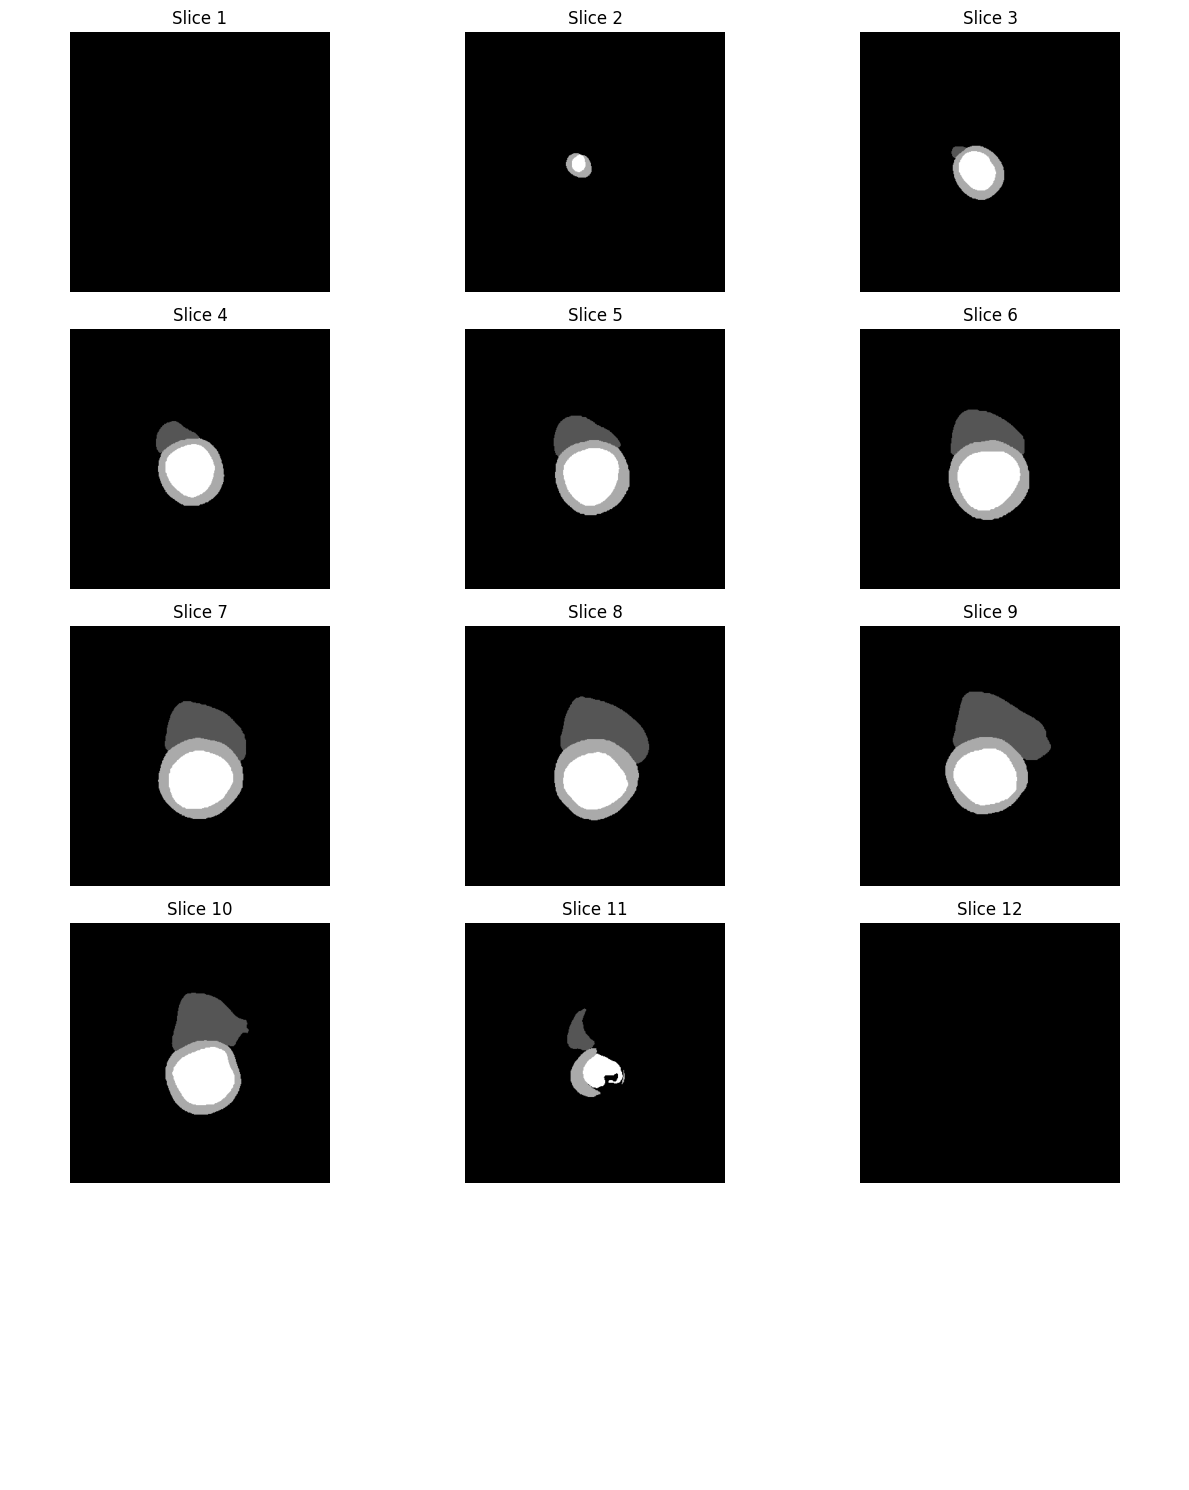

In [ ]:
num_slices = image_data.shape[2]
slice_indices = range(num_slices)
# Create a subplot (5 rows x 3 columns)
fig, axes = plt.subplots(5, 3, figsize=(12, 15))
# Loop through each subplot and plot the corresponding slice
for i, ax in enumerate(axes.flat):
    if i < len(slice_indices):
        slice_idx = slice_indices[i]
        ax.imshow(image_data[:, :, slice_idx], cmap="gray")
        ax.set_title(f"Slice {slice_idx+1}")
        ax.axis("off")
    else:
        ax.axis("off")  # Turn off empty subplots

plt.tight_layout()
plt.show()

### Con borde interior

In [ ]:
def nifti_to_mesh(nifti_file, start_slice=0):
  nifti_data = nib.load(nifti_file)
  # Extract the image data as a NumPy array
  image_data = nifti_data.get_fdata()
  spacing = nifti_data.header.get_zooms()
  voxel_x = spacing[0]
  voxel_y = spacing[1]
  voxel_z =  spacing[2]
  N_x = image_data.shape[0]
  N_y = image_data.shape[1]
  num_slices = image_data.shape[2]
  rng_x = N_x*voxel_x//2
  rng_y = N_y*voxel_y//2
  rng_z = num_slices*voxel_z/2
  edges_s  = []
  end_slice_ = num_slices-start_slice
  for i in range(end_slice_):
    slice_ = np.transpose(image_data[:, :, i]) ## Corrige que la imagen esta relfejada
    # Se crea mallado base
    x = np.linspace(-rng_x, rng_x, N_x)  # 100 points along x-axis
    y = np.linspace(-rng_y, rng_y, N_y)  # 100 points along y-axis
    # Create a grid of points
    x, y = np.meshgrid(x, y)
    h = voxel_z*i #altura de la imagen
    z = -rng_z + np.ones_like(x)*h
    surface = pv.StructuredGrid(x, y, z)
    surface["values"] = slice_.flatten()
    edges = surface.threshold((1,2)).extract_feature_edges()
    if len(edges.points) > 0:
      edges_s.append(edges)
  return point_cloud(edges_s)

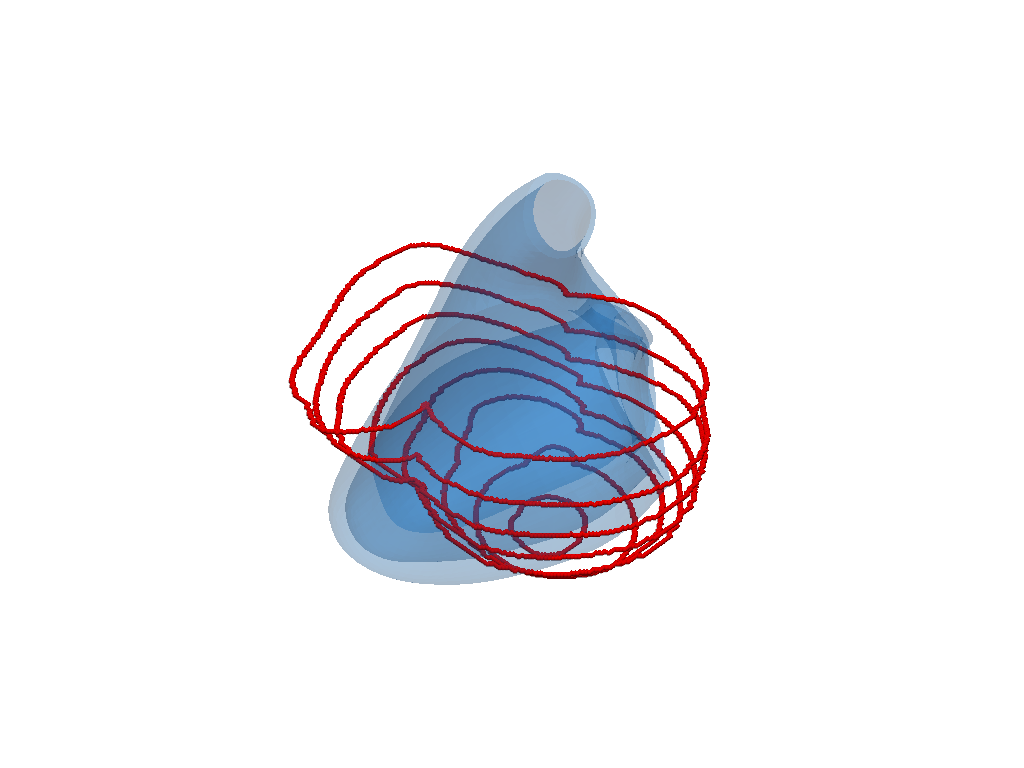

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_1.nii', 3)
affine = nifti_data.affine
rotation_matrix = affine[:3, :3]
inverse_rotation = np.linalg.inv(rotation_matrix)
mesh = mesh_heart(np.zeros(1))

# Convert to 4x4 transformation matrix
transf = np.eye(4)
transf[:3, :3] = rotation_matrix  # Embed the 3x3 matrix

# Apply the inverse rotation to the mesh
#data.transform(transf)
# Visualize the reoriented mesh
aligned = data.align(mesh)
p = pv.Plotter()
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
#p.add_mesh(aligned, render_points_as_spheres=True, color = 'green')
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.show()
pv.save_meshio("data.vtk", data)
pv.save_meshio("mesh.vtk", mesh)

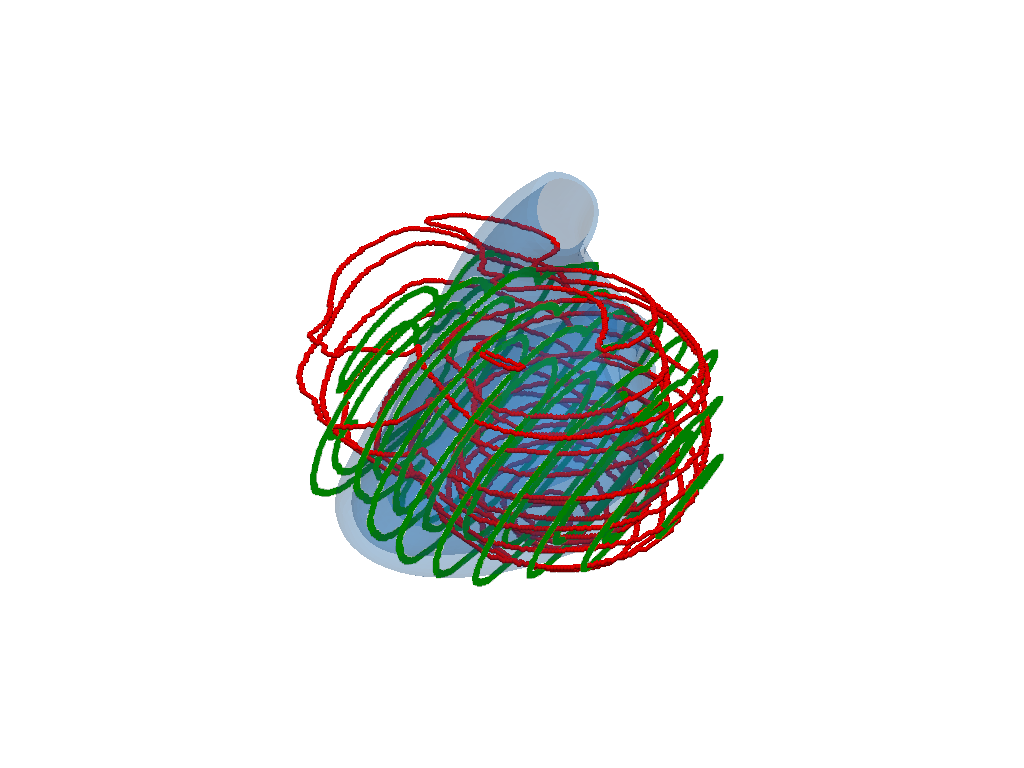

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_1.nii')
alpha_real = np.zeros(5)
mesh = mesh_heart(alpha_real)
aligned = data.align(mesh, max_iterations=1000, max_landmarks=500)
p = pv.Plotter()
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(aligned, color = 'green', show_edges = True)
p.show()

In [ ]:
data_points = aligned.points
modes = 5
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
err_real = loss(alpha_real, opt_points)
print('Loss mínimo:' + str(min(loss_rec)))

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [-2.66856587 -8.86755756  5.48223547 -9.57693837 -0.04721773]
Loss mínimo:13.827163123437964


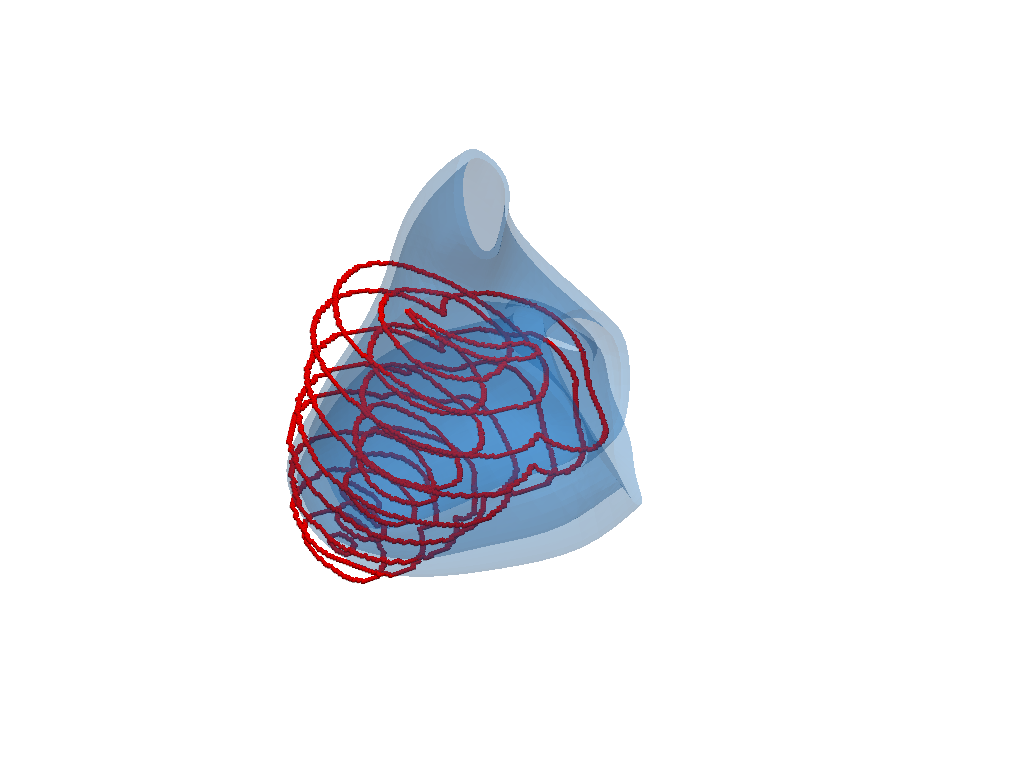

In [ ]:
mesh_opt  = mesh_heart(alpha_opt)
p = pv.Plotter()
p.add_mesh(aligned, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.show()

### Sin borde interior

In [ ]:
def nifti_to_mesh(nifti_file, start_slice=0):
  nifti_data = nib.load(nifti_file)
  # Extract the image data as a NumPy array
  image_data = nifti_data.get_fdata()
  spacing = nifti_data.header.get_zooms()
  voxel_x = spacing[0]
  voxel_y = spacing[1]
  voxel_z =  spacing[2]
  N_x = image_data.shape[0]
  N_y = image_data.shape[1]
  num_slices = image_data.shape[2]
  rng_x = N_x*voxel_x//2
  rng_y = N_y*voxel_y//2
  rng_z = num_slices*voxel_z/2
  edges_s  = []
  end_slice_ = num_slices-start_slice
  for i in range(end_slice_):
    slice_ = np.transpose(image_data[:, :, i]) ## Corrige que la imagen esta relfejada
    # Se crea mallado base
    x = np.linspace(-rng_x, rng_x, N_x)  # 100 points along x-axis
    y = np.linspace(-rng_y, rng_y, N_y)  # 100 points along y-axis
    # Create a grid of points
    x, y = np.meshgrid(x, y)
    h = voxel_z*i #altura de la imagen
    z = -rng_z + np.ones_like(x)*h
    surface = pv.StructuredGrid(x, y, z)
    surface["values"] = slice_.flatten()
    edges = surface.threshold((1,3)).extract_feature_edges()
    if len(edges.points) > 0:
      edges_s.append(edges)
  return point_cloud(edges_s)

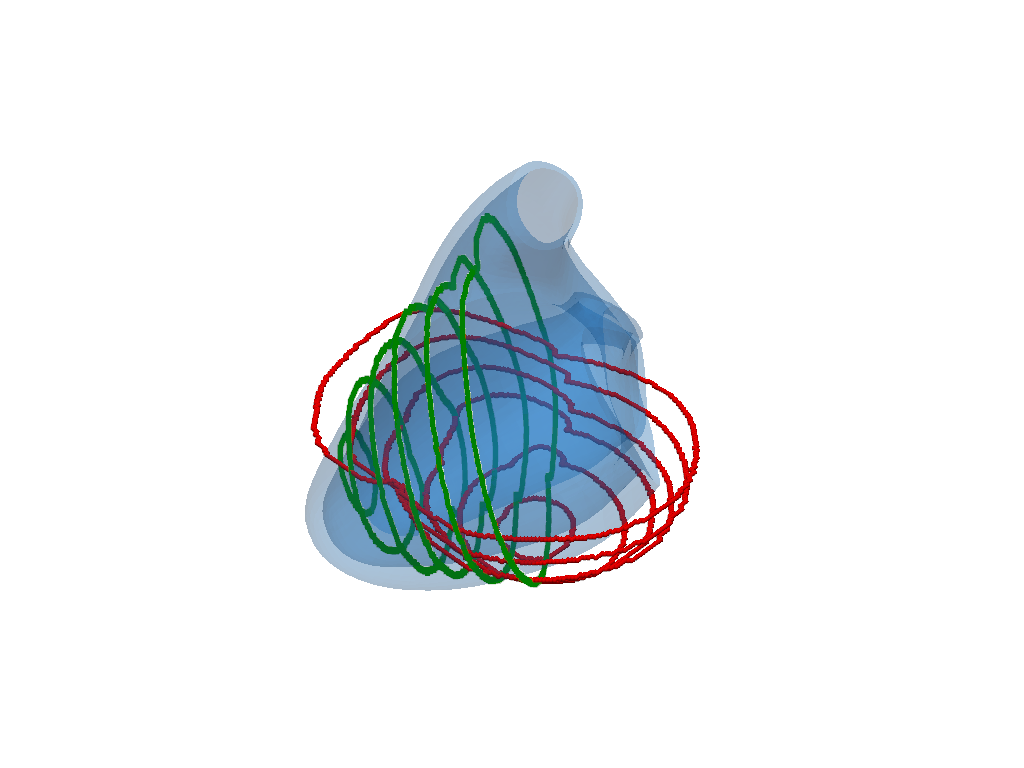

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_1.nii', 5)
alpha_real = np.zeros(5)
mesh = mesh_heart(alpha_real)
aligned = data.align(mesh, max_iterations=1000, max_landmarks=500)
p = pv.Plotter()
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.add_mesh(aligned, color = 'green', show_edges = True)
p.show()

In [ ]:
data_points = aligned.points
modes = 5
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec  = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
err_real = loss(alpha_real, opt_points)
print('Loss mínimo:' + str(min(loss_rec)))

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [-0.02420376 -0.8899606   1.95996339 -1.29726956 -1.0004565 ]
Loss mínimo:3.074224006913933


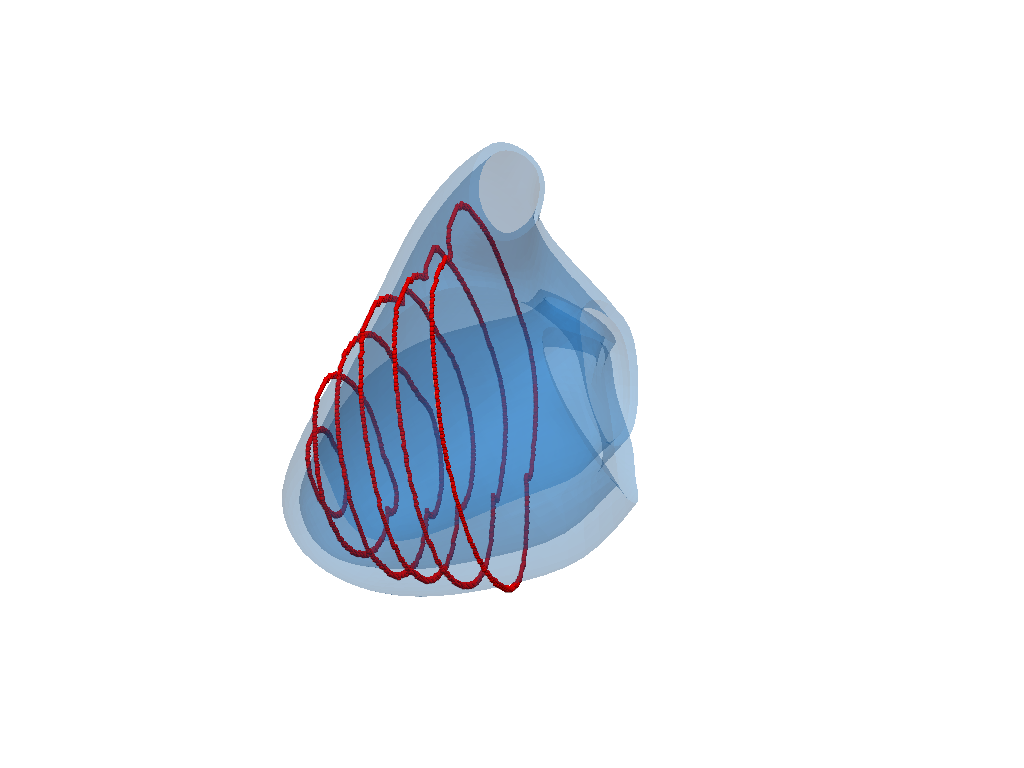

In [ ]:
mesh_opt  = mesh_heart(alpha_opt)
p = pv.Plotter()
p.add_mesh(aligned, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.2, render_points_as_spheres=True, color = 'dodgerblue')
p.show()